# Crude Oil Multi-Factor Walkforward Strategy

**Disclaimer:** The strategy logic, hypothesis generation, and research direction were independently developed by the author. AI assistance was utilized solely for code generation and syntax correction.


This notebook walks through how I built and evaluated a **multi-factor walkforward trading strategy** for Brent Crude Oil futures (`CO1 Comdty`).

Here's what we'll cover:

1. **Exploring** the statistical properties of crude oil returns (seasonality, autocorrelation, volatility clustering, fat tails)
2. **Building** multiple trading signals: momentum, moving-average crossovers, and dollar-index-based strategies
3. **Adding** risk management with volatility targeting, minimum holding periods, and stop losses
4. **Picking** the best-performing strategy each quarter using a walkforward backtester
5. **Evaluating** portfolio performance, drawdowns, and parameter sensitivity

---

## 1. Setup & Imports

In [2]:
import pandas as pd
import plotly.io as pio
pio.renderers.default = "svg"


### 1.1 Walkforward Backtester

In [3]:
from dataclasses import dataclass, field
from typing import Callable, List, Dict

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
pd.options.plotting.backend = 'plotly'


@dataclass
class WalkforwardBacktester:
    """
    A basic Walkforward Backtester for comparing multiple strategies over a rolling
    lookback period and applying the best performing strategy to the next period.

    Attributes
    ----------
    pnl_df : pd.DataFrame
        DataFrame of PnL/returns for multiple strategies. Columns represent strategies,
        index is datetime.
    lookback_period : str
        Lookback period for evaluating strategy performance (e.g., '24M' for 24 months).
    rebalance_freq : str
        Frequency of rebalance (e.g., '3M' = every 3 months).
    score_func : Callable
        Function to score each strategy's performance on the lookback period. Defaults to Sharpe ratio.
    periods : List
        List of rebalance period start dates (filled during backtest run).
    lookback_start_skip_check : bool
        If True, allows lookback start to go before the start of available data.

    Example
    -------
    backtester = WalkforwardBacktester(
        pnl_df=pnl_strategies,
        lookback_period='24M',
        rebalance_freq='3M'
    )
    portfolio_pnl = backtester.run_backtest()
    """

    pnl_df: pd.DataFrame
    lookback_period: str
    rebalance_freq: str
    score_func: Callable[[pd.Series], float] = field(default=None)
    periods: List = None
    lookback_start_skip_check: bool = False
    rebalances: List[Dict[str, any]] = field(default_factory=list)

    def __post_init__(self):
        """Initialize default scoring function and empty portfolio series."""
        self.score_func = self.score_func or self._sharpe_ratio
        self.portfolio_pnl = pd.Series(index=self.pnl_df.index, dtype=np.float64)

    def _sharpe_ratio(self, returns: pd.Series) -> float:
        """Default scoring function: Sharpe ratio."""
        return returns.mean() / returns.std() if returns.std() != 0 else 0

    def _select_best_strategy(self, lookback_df: pd.DataFrame) -> str:
        """
        Evaluate all strategies in the lookback period and select the one with highest score.

        Returns
        -------
        best_strategy : str
            Name of the strategy with the best score
        strategy_scores : pd.Series
            Scores for all strategies
        """
        strategy_scores = lookback_df.apply(self.score_func)
        return strategy_scores.idxmax(), strategy_scores

    def run_backtest(self) -> pd.Series:
        """
        Run the walkforward backtest. At each rebalance period, select the best strategy
        based on the lookback period and apply it forward.

        Returns
        -------
        portfolio_pnl : pd.Series
            Series of portfolio returns following the walkforward strategy.
        """
        # Ensure rebalance and lookback frequencies are in months

        # Normalise freq aliases: accept both "3M" and "3ME"
        def _norm(freq):
            if freq.endswith('ME'):
                return freq, int(freq[:-2])
            elif freq.endswith('M'):
                return freq[:-1] + 'ME', int(freq[:-1])
            raise ValueError(f"Frequency {freq} must end with M or ME")

        rb_freq, rb_months = _norm(self.rebalance_freq)
        lb_freq, lb_months = _norm(self.lookback_period)

        # Create rebalance period start dates
        self.periods = pd.date_range(
            start=self.pnl_df.index[0],
            end=self.pnl_df.index[-1] + relativedelta(months=rb_months),
            freq=rb_freq
        )

        # Loop over rebalance periods
        for start_date, end_date in zip(self.periods[:-1], self.periods[1:]):
            # Lookback period ends 1 day before rebalance start
            lookback_end = start_date - pd.Timedelta(days=1)
            lookback_start = lookback_end - relativedelta(months=lb_months)

            # Skip if lookback starts before available data
            if (lookback_start < self.pnl_df.index[0]) and (not self.lookback_start_skip_check):
                continue

            lookback_df = self.pnl_df.loc[lookback_start:lookback_end]
            best_strat, strategy_scores = self._select_best_strategy(lookback_df)

            # Store details for analysis
            self.rebalances.append({
                'start_date': start_date,
                'end_date': end_date,
                'lookback_start': lookback_start,
                'lookback_end': lookback_end,
                'best_strategy': best_strat,
                'strategy_scores': strategy_scores,
                'lookback_df': lookback_df,
                'selected_strategy_mean_returns': self.pnl_df[best_strat].loc[start_date:end_date].mean(),
                'selected_strategy_mean_std': self.pnl_df[best_strat].loc[start_date:end_date].std()
            })

            # Apply the selected strategy's returns to portfolio
            self.portfolio_pnl.loc[start_date:end_date] = self.pnl_df[best_strat].loc[start_date:end_date]

        return self.portfolio_pnl

    def get_rebalance_details(self) -> pd.DataFrame:
        """Return DataFrame of rebalance period decisions and metrics."""
        return pd.DataFrame(self.rebalances)




---
## 2. Data Loading

In [4]:
df = pd.read_excel(r"brent_index.xlsx", parse_dates=['date'], index_col='date')
rets = df['CO1 Comdty'].pct_change()

In [5]:
df.shape

(2174, 1)

---
## 3. Exploratory Data Analysis (EDA)

Before we build any trading signals, we need to understand what crude oil returns actually look like. This section digs into the key statistical properties that will guide our strategy choices.

### 3.1 Price Chart with Trend Lines

Here we plot the raw price along with 50-day and 200-day moving averages. The green shaded areas mark uptrend periods (when price is above the 200-day MA). This gives us a visual sense of how trendy crude oil is, which is why momentum strategies might work well here.

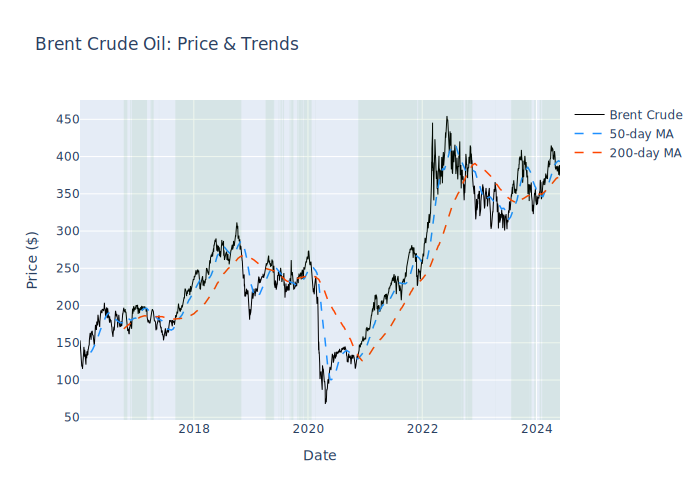

In [6]:
# Price chart with trend lines
import plotly.graph_objects as go

price = df['CO1 Comdty']
ma_50  = price.rolling(50).mean()
ma_200 = price.rolling(200).mean()

fig = go.Figure()

# Plot the raw price
fig.add_trace(go.Scatter(x=price.index, y=price, name='Brent Crude',
                         line=dict(color='black', width=1)))

# Add moving averages
fig.add_trace(go.Scatter(x=ma_50.index, y=ma_50, name='50-day MA',
                         line=dict(color='dodgerblue', width=1.5, dash='dash')))
fig.add_trace(go.Scatter(x=ma_200.index, y=ma_200, name='200-day MA',
                         line=dict(color='orangered', width=1.5, dash='dash')))

# Shade uptrend regions (price above 200-day MA)
uptrend = price > ma_200
for i in range(1, len(price)):
    if uptrend.iloc[i] and not uptrend.iloc[i-1]:  # uptrend starts
        start = price.index[i]
    elif (not uptrend.iloc[i] and uptrend.iloc[i-1]) or (i == len(price)-1 and uptrend.iloc[i]):
        fig.add_vrect(x0=start, x1=price.index[i],
                      fillcolor='green', opacity=0.07, line_width=0)

fig.update_layout(title='Brent Crude Oil: Price & Trends',
                  xaxis_title='Date', yaxis_title='Price ($)',
                  height=500, hovermode='x unified')
fig.show()


### 3.2 Seasonality Analysis

Crude oil has seasonal patterns driven by things like refinery maintenance cycles, heating and cooling demand, and summer driving season. Let's look at:
- **Average monthly returns** to see which months tend to be bullish or bearish
- **A year-by-year heatmap** to check how consistent these patterns really are

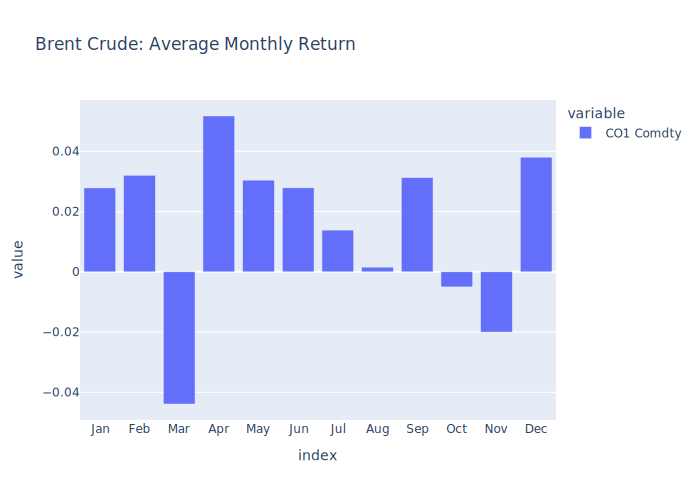

In [7]:
# Average return by month (seasonality)
monthly_avg = rets.groupby(rets.index.month).mean() * 21  # roughly one month of trading days
monthly_avg.index = ['Jan','Feb','Mar','Apr','May','Jun',
                     'Jul','Aug','Sep','Oct','Nov','Dec']

fig = monthly_avg.plot(kind='bar', title='Brent Crude: Average Monthly Return')
fig.show()


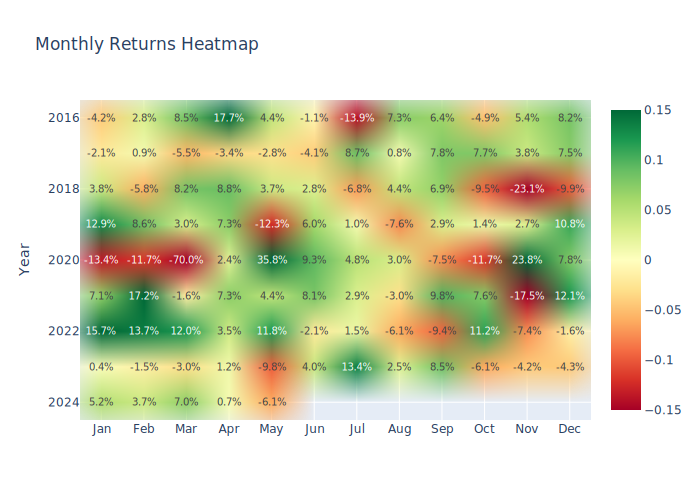

In [8]:
# Seasonality heatmap
import plotly.express as px

monthly = rets.resample('ME').sum()                        # sum daily returns into monthly
monthly_df = pd.DataFrame({
    'Year': monthly.index.year,
    'Month': monthly.index.month,
    'Return': monthly.values
})
pivot = monthly_df.pivot(index='Year', columns='Month', values='Return')
pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun',
                 'Jul','Aug','Sep','Oct','Nov','Dec']

fig = px.imshow(pivot, color_continuous_scale='RdYlGn', aspect='auto',
                title='Monthly Returns Heatmap',
                zmin=-0.15, zmax=0.15,          # clamp to +/-15%
                text_auto='.1%')                 # show numbers in cells
fig.show()


### 3.3 Return Autocorrelation

Autocorrelation tells us whether today's return has any relationship with past returns. If we see significant positive autocorrelation at short lags, that's a green light for **momentum** strategies. Significant negative autocorrelation would point toward **mean reversion** instead.

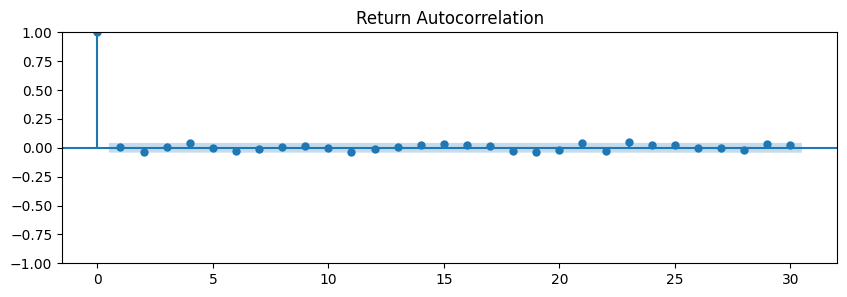

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(rets.dropna(), lags=30, ax=ax, title='Return Autocorrelation')
plt.show()

### 3.4 Volatility Clustering

One well-known feature of commodity markets: volatility clusters. Big moves tend to follow big moves, and calm periods follow calm periods. This is exactly why we use a **rolling volatility scalar** for position sizing instead of fixed lot sizes. When vol is high, we reduce our position size, and vice versa.

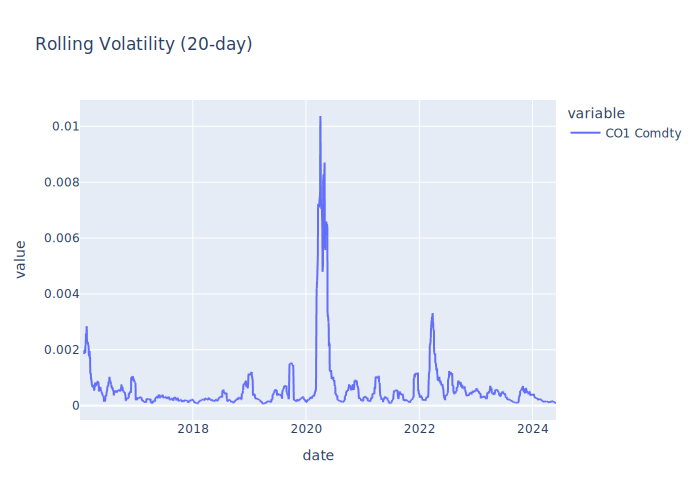

In [10]:
(rets.dropna()**2).rolling(20).mean().plot(title='Rolling Volatility (20-day)')

### 3.5 Return Distribution

Let's look at the histogram of daily returns along with skewness and kurtosis:
- **Negative skew** means there are more large crashes than rallies (this supports using stop losses)
- **High kurtosis** (above 3) means fat tails, so extreme moves happen more often than a normal distribution would predict

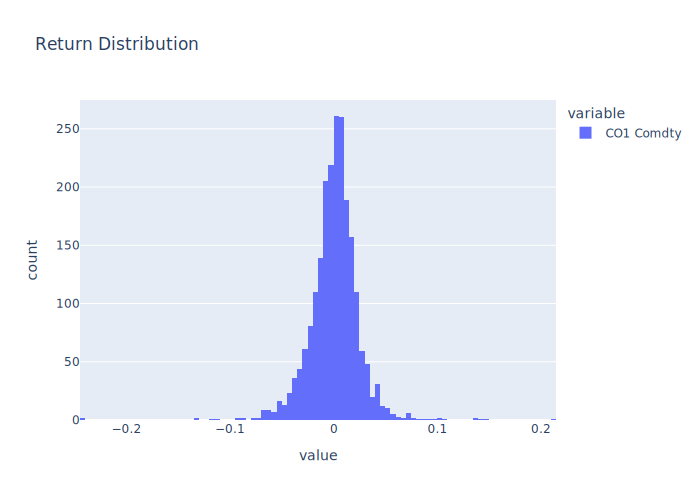

Skew:     -0.53
Kurtosis: 14.01


In [11]:
import plotly.express as px
fig = px.histogram(rets.dropna(), nbins=100, title='Return Distribution')
fig.show()

print(f"Skew:     {rets.skew():.2f}")    # negative means more crashes than rallies
print(f"Kurtosis: {rets.kurtosis():.2f}") # above 3 means fat tails, extreme moves


### 3.6 Drawdown Analysis

Drawdowns measure the decline from a peak to a trough in cumulative returns. Understanding how deep and how long historical drawdowns have been helps us set realistic stop-loss thresholds and manage our expectations.

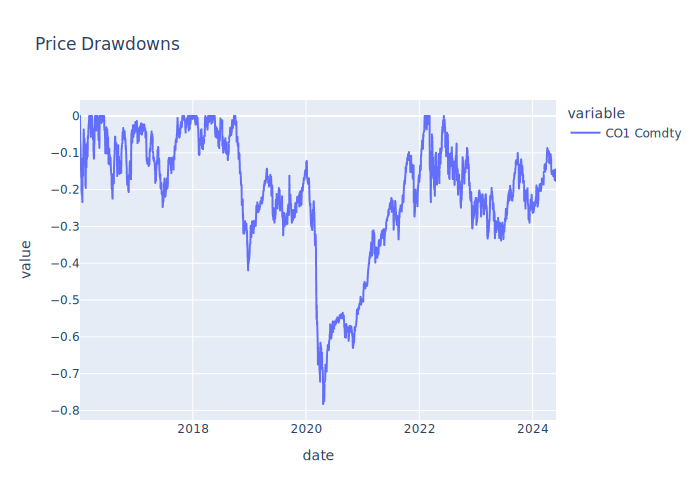

In [12]:
cum = (1 + rets.dropna()).cumprod()
drawdown = cum / cum.cummax() - 1
drawdown.plot(title='Price Drawdowns')

### 3.7 Worst Days

Let's find the 10 worst single-day drops. Were these driven by surprise events (geopolitics, COVID, OPEC decisions), or was there some warning in the price action beforehand?

In [13]:
# The 10 worst single-day drops
worst = rets.dropna().nsmallest(10)
print(worst)


date
2020-04-21   -0.244036
2020-03-09   -0.240998
2020-03-18   -0.134006
2022-03-09   -0.131583
2021-11-26   -0.115544
2020-03-16   -0.112260
2022-07-05   -0.094537
2020-03-06   -0.094419
2020-04-20   -0.089387
2020-03-30   -0.087044
Name: CO1 Comdty, dtype: float64


---
## 4. External Data: U.S. Dollar Index (DXY)

Since crude oil is priced in USD, there's a well-known inverse relationship between the dollar and oil prices. When the dollar weakens, oil gets cheaper for foreign buyers, which tends to boost global demand and push prices up.

We'll pull the Trade-Weighted U.S. Dollar Index from FRED and line it up with our price data so we can use it as a cross-asset trading signal.

In [14]:
# Load DXY (U.S. Dollar Index) from our local CSV
dxy = pd.read_csv("dxy.csv", index_col="observation_date", parse_dates=True)
dxy.columns = ["DXY"]
dxy = dxy.reindex(rets.index).ffill()


---
## 5. Strategy Construction & Backtesting

This is the core section of the notebook. We'll build **multiple trading strategies**, each generating daily long/short signals, and then run them all through the walkforward backtester.

### 5.1 Parameters & Risk Management Helpers

Here are the key parameters we're using:

| Parameter | Value | What it does |
|-----------|-------|--------------|
| `tcost` | 1.5 bps | Transaction cost deducted per trade |
| `lookback_days` | [20, 30, 60, 120, 200] | Windows for momentum signals |
| `vol_target` | 15% annual | Target volatility for position sizing |
| `min_hold` | 10 days | Minimum holding period to cut down on whipsaws |
| `stop_loss` | -3% | Exit if a trade's cumulative P&L drops below this |

**Helper functions:**
- `apply_min_hold()` prevents the signal from flipping for at least `min_days`, which reduces unnecessary turnover
- `apply_stop_loss()` forces an exit (go flat) if a trade's cumulative return hits the stop-loss threshold

**The strategies we're building:**
1. **Momentum** - go long if the N-day return is positive, short otherwise
2. **Mean Reversion** *(commented out, didn't work for crude oil)*
3. **MA Crossover** - go long when the fast MA crosses above the slow MA (classic trend-following)
4. **DXY-based** - go long on oil when the dollar is weakening (fast DXY MA below slow DXY MA)
5. **Inventory-based** *(commented out, the signal wasn't strong enough for daily trading)*

All signals are **volatility-scaled** to target 15% annualized vol and include transaction costs.

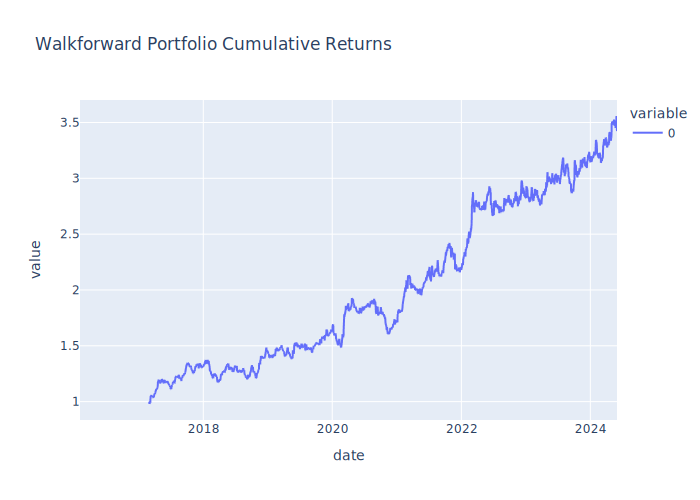

In [15]:
# Parameters
tcost = 0.00015                              # 1.5 bps transaction cost
lookback_days = [20, 30, 60, 120, 200]    # only keeping long-term windows (dropped 1D, 5D, 10D)
vol_window = 20                              # volatility lookback window
vol_target = 0.15                            # target 15% annualized vol
min_hold = 10                                 # minimum holding period in days
stop_loss = -0.03                        # -3% stop loss threshold

pnl_strategies = pd.DataFrame(index=rets.index)
price = df['CO1 Comdty']


# Helper: apply minimum holding period
def apply_min_hold(signal, min_days):
    """Prevent signal from flipping for at least min_days."""
    out = signal.copy()
    hold_counter = 0
    for i in range(1, len(out)):
        if hold_counter > 0:
            out.iloc[i] = out.iloc[i - 1]    # force hold
            hold_counter -= 1
        elif out.iloc[i] != out.iloc[i - 1]:
            hold_counter = min_days           # signal changed, start holding
    return out

# Helper: apply stop loss
def apply_stop_loss(signal, rets, threshold):
    """Exit position (go flat) if cumulative trade return hits stop loss."""
    out = signal.copy()
    cum_trade_ret = 0.0
    for i in range(1, len(out)):
        if out.iloc[i] != 0:
            cum_trade_ret += out.iloc[i] * rets.iloc[i]
            if cum_trade_ret < threshold:
                out.iloc[i] = 0              # stop out, go flat
                cum_trade_ret = 0.0
        if out.iloc[i] != out.iloc[i - 1]:
            cum_trade_ret = 0.0              # new trade, reset

    return out

# Volatility scalar for risk parity sizing
ann_vol = rets.rolling(vol_window).std() * np.sqrt(252)
vol_scalar = (vol_target / ann_vol).shift(1)   # shift to avoid look-ahead bias



# 1. Momentum strategies
for n in lookback_days:
    signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)
    signal = apply_stop_loss(signal, rets, stop_loss)
  
    scaled = signal * vol_scalar
    pnl_strategies[f'{n}D_momentum'] = scaled * rets - tcost * scaled.diff().abs()


# 2. Mean Reversion (commented out because it didn't work for crude)
# for n in lookback_days:
#     signal = (df['CO1 Comdty'].pct_change(n).shift(1) > 0) * 2 - 1
#     signal = -signal
#     signal = apply_min_hold(signal, min_hold)
#     signal = apply_stop_loss(signal, rets, stop_loss)
#     scaled = signal * vol_scalar
#     pnl_strategies[f'{n}D_meanrev'] = scaled * rets - tcost * scaled.diff().abs()


    
# 3. MA crossover strategies
ma_pairs = [(5, 20), (10, 50), (20, 100), (50, 200), (10, 30), (20, 60)]
for fast, slow in ma_pairs:
    fast_ma = price.rolling(fast).mean()
    slow_ma = price.rolling(slow).mean()
    signal = (fast_ma.shift(1) > slow_ma.shift(1)) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)

    scaled = signal * vol_scalar
    pnl_strategies[f'{fast}_{slow}_ma_cross'] = scaled * rets - tcost * scaled.diff().abs()



# 4. DXY-based strategies (dollar weakness = bullish for oil)
dxy_pairs = [(5, 20), (10, 50), (20, 100)]
for fast, slow in dxy_pairs:
    fast_ma = dxy['DXY'].rolling(fast).mean()
    slow_ma = dxy['DXY'].rolling(slow).mean()
    # Dollar fast MA below slow MA means dollar is weakening, which is bullish for oil
    signal = (fast_ma.shift(1) < slow_ma.shift(1)) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)
    signal = apply_stop_loss(signal, rets, stop_loss)
    scaled = signal * vol_scalar
    pnl_strategies[f'dxy_{fast}_{slow}'] = scaled * rets - tcost * scaled.diff().abs()


# Inventory signal (commented out, wasn't strong enough for daily trading)
# inv_signal = np.where(stock_change.shift(1) < 0, 1, -1)  # shift to avoid look-ahead
# inv_signal = pd.Series(inv_signal, index=rets.index)
# pnl_strategies['inventory'] = inv_signal * rets - tcost * inv_signal.diff().abs()

# Run the walkforward backtest
bt = WalkforwardBacktester(
    pnl_df=pnl_strategies.dropna(),
    lookback_period='12M',
    rebalance_freq='3M'
)
portfolio = bt.run_backtest()

# Plot cumulative returns
portfolio_cum = (1 + portfolio).cumprod()
portfolio_cum.plot(title="Walkforward Portfolio Cumulative Returns")


---
## 6. Portfolio Performance Analysis

Now let's see how the walkforward portfolio actually performed.

### 6.1 Individual Strategy Cumulative Returns

First, let's visualize the cumulative P&L of every individual strategy. This helps us see which ones contributed positively and which ones were net losers.

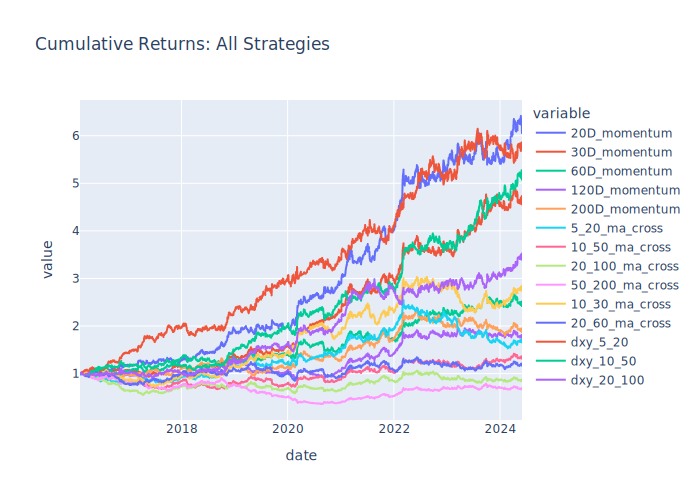

In [16]:
# Plot cumulative returns for all individual strategies
cum_all = (1 + pnl_strategies.dropna()).cumprod()
cum_all.plot(title='Cumulative Returns: All Strategies')


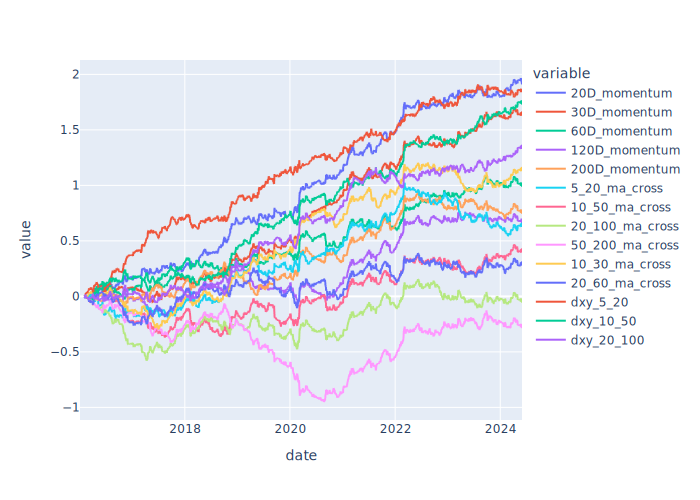

In [17]:
pnl_strategies.cumsum().plot()

### 6.2 Portfolio Performance Metrics

Here are the key numbers for the walkforward portfolio:
- **Sharpe Ratio** measures risk-adjusted return (we're aiming for above 1.0)
- **Calmar Ratio** is return divided by max drawdown
- **Win Rate** is the percentage of days with positive returns
- **Profit Factor** is gross profit divided by gross loss

In [18]:
# Portfolio performance metrics
net = portfolio.dropna()
cum = (1 + net).cumprod()

ann_return  = net.mean() * 252
ann_vol     = net.std() * (252 ** 0.5)
sharpe      = ann_return / ann_vol if ann_vol != 0 else 0
max_dd      = (cum / cum.cummax() - 1).min()
calmar      = ann_return / abs(max_dd) if max_dd != 0 else 0
win_rate    = (net > 0).mean()
profit_fac  = net[net > 0].sum() / abs(net[net < 0].sum()) if (net < 0).any() else float('inf')
total_ret   = cum.iloc[-1] - 1

print(f"""
{'='*45}
  * SHARPE RATIO   : {sharpe:>8.2f} *
{'='*45}
  Total Return     : {total_ret:>8.2%}
  Ann. Return      : {ann_return:>8.2%}
  Ann. Volatility  : {ann_vol:>8.2%}
  Max Drawdown     : {max_dd:>8.2%}
  Calmar Ratio     : {calmar:>8.2f}
  Win Rate         : {win_rate:>8.2%}
  Profit Factor    : {profit_fac:>8.2f}
{'='*45}
""")



  * SHARPE RATIO   :     1.11 *
  Total Return     :  242.29%
  Ann. Return      :   17.83%
  Ann. Volatility  :   16.05%
  Max Drawdown     :  -16.80%
  Calmar Ratio     :     1.06
  Win Rate         :   52.05%
  Profit Factor    :     1.21



### 6.3 Time in Market

Quick sanity check: if the strategy spends most of its time out of the market, our stop loss is probably too aggressive.

In [19]:
# How much time is the strategy actually in the market?
in_market = (portfolio != 0).mean()
print(f"Time in market: {in_market:.1%}")
# If this is below ~50%, the stop loss might be too tight


Time in market: 99.9%


### 6.4 Turnover Analysis

How often does the portfolio actually trade? Too much turnover eats into returns through transaction costs.

In [20]:
# Total transactions (strategy switches + signal flips)
total_trades = portfolio.diff().ne(0).sum()
years = len(portfolio.dropna()) / 252
print(f"Total transactions: {total_trades}")
print(f"Trading period: {years:.1f} years")
print(f"Trades per year: {total_trades / years:.0f}")


Total transactions: 2152
Trading period: 7.4 years
Trades per year: 289


### 6.5 Strategy Drawdown

Unlike the raw asset drawdown we looked at in Section 3.6, this one shows how our **actual strategy** performed. How much did our portfolio lose from its peak at the worst point?

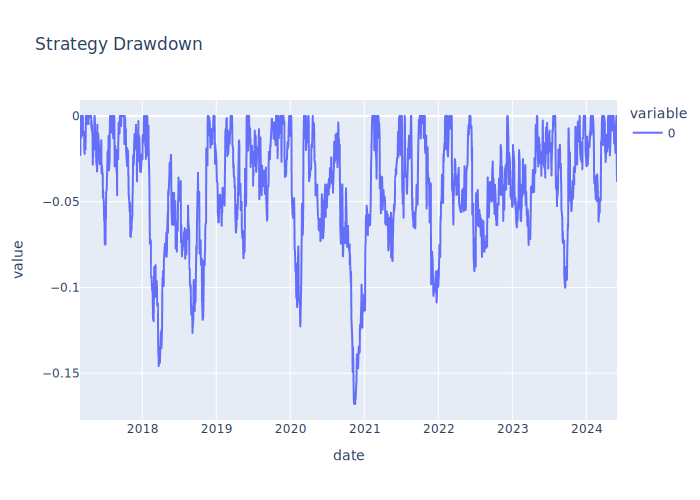

In [21]:
# How bad does our strategy get (not just the raw asset)?
strat_cum = (1 + portfolio.dropna()).cumprod()
strat_dd = strat_cum / strat_cum.cummax() - 1
strat_dd.plot(title='Strategy Drawdown')


### 6.6 Strategy Selection Analysis

Which strategies got picked most often by the walkforward optimizer? This tells us which factors dominated across different market environments.

In [22]:
# Which strategy gets picked the most?
rebal = bt.get_rebalance_details()

# Calculate how long each period lasted in months
rebal['months'] = ((rebal['end_date'] - rebal['start_date']).dt.days / 30.44).round(1)

# Summary: count of picks + total months for each strategy
summary = rebal.groupby('best_strategy').agg(
    picks=('best_strategy', 'count'),
    total_months=('months', 'sum')
).sort_values('total_months', ascending=False)

summary['pct_time'] = (summary['total_months'] / summary['total_months'].sum() * 100).round(1)

print(summary.to_string())


                 picks  total_months  pct_time
best_strategy                                 
dxy_10_50            7          21.0      23.3
20D_momentum         6          18.0      20.0
dxy_5_20             5          15.0      16.7
10_30_ma_cross       2           6.0       6.7
120D_momentum        2           6.0       6.7
30D_momentum         2           6.0       6.7
60D_momentum         2           6.0       6.7
dxy_20_100           2           6.0       6.7
20_100_ma_cross      1           3.0       3.3
20_60_ma_cross       1           3.0       3.3


### 6.7 Equity Curve Colored by Active Strategy

Here's the equity curve with each segment colored based on which strategy was active at the time. This makes it easy to see **regime changes** and which strategy the backtester chose each quarter.

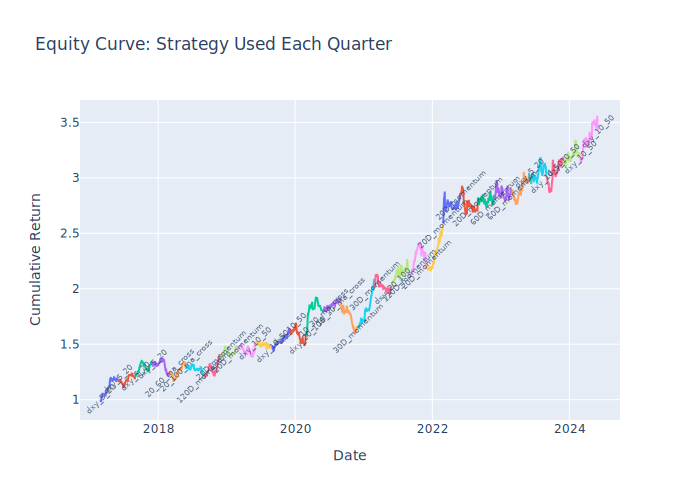

In [23]:
# Equity curve colored by which strategy was active
import plotly.graph_objects as go

cum = (1 + portfolio.dropna()).cumprod()
rebal = bt.get_rebalance_details()

fig = go.Figure()

# Draw each segment in a different color based on the strategy
for _, row in rebal.iterrows():
    mask = (cum.index >= row['start_date']) & (cum.index <= row['end_date'])
    segment = cum[mask]
    if len(segment) == 0:
        continue
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment.values,
        mode='lines', name=row['best_strategy'],
        showlegend=False,
        hovertemplate=f"{row['best_strategy']}<br>%{{x}}<br>%{{y:.4f}}"
    ))
    # Label at the start of each segment
    fig.add_annotation(
        x=segment.index[0], y=segment.values[0],
        text=row['best_strategy'], showarrow=False,
        textangle=-45, font=dict(size=8), opacity=0.7
    )

fig.update_layout(title='Equity Curve: Strategy Used Each Quarter',
                  xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


### 6.8 Equity Curve with Metrics Overlay

A dashboard-style view that puts it all together: the equity curve, key metrics, and strategy usage breakdown in one chart.

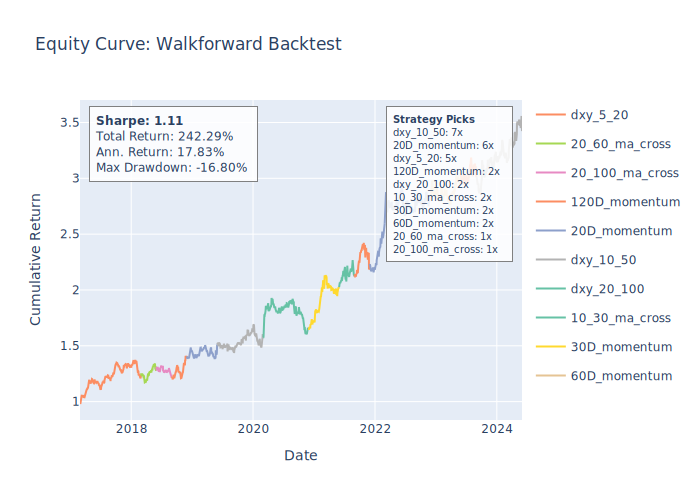

In [24]:
# Equity curve with metrics and strategy breakdown
import plotly.graph_objects as go
import plotly.colors as pc

cum = (1 + portfolio.dropna()).cumprod()
net = portfolio.dropna()
rebal = bt.get_rebalance_details()

# Compute metrics
ann_return  = net.mean() * 252
ann_vol     = net.std() * (252 ** 0.5)
sharpe      = ann_return / ann_vol if ann_vol != 0 else 0
max_dd      = (cum / cum.cummax() - 1).min()
total_ret   = cum.iloc[-1] - 1
strat_counts = rebal['best_strategy'].value_counts()

# Assign a fixed color to each strategy
all_strats = sorted(rebal['best_strategy'].unique())
palette = pc.qualitative.Set2
color_map = {s: palette[i % len(palette)] for i, s in enumerate(all_strats)}

fig = go.Figure()

# Keep track of which strategies we've already added to the legend
legend_added = set()

for _, row in rebal.iterrows():
    mask = (cum.index >= row['start_date']) & (cum.index <= row['end_date'])
    segment = cum[mask]
    if len(segment) == 0:
        continue
    strat = row['best_strategy']
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment.values,
        mode='lines', name=strat,
        line=dict(color=color_map[strat], width=2),
        showlegend=strat not in legend_added,
        legendgroup=strat,
        hovertemplate=f"{strat}<br>%{{x}}<br>%{{y:.4f}}"
    ))
    legend_added.add(strat)

# Metrics text box (top-left corner)
metrics_text = (
    f"<b>Sharpe: {sharpe:.2f}</b><br>"
    f"Total Return: {total_ret:.2%}<br>"
    f"Ann. Return: {ann_return:.2%}<br>"
    f"Max Drawdown: {max_dd:.2%}"
)
fig.add_annotation(
    x=0.02, y=0.98, xref='paper', yref='paper',
    text=metrics_text, showarrow=False,
    font=dict(size=12), align='left',
    bordercolor='gray', borderwidth=1, borderpad=6,
    bgcolor='rgba(255,255,255,0.85)'
)

# Strategy usage text box (top-right corner)
usage_text = "<b>Strategy Picks</b><br>" + "<br>".join(
    f"{name}: {count}x" for name, count in strat_counts.items()
)
fig.add_annotation(
    x=0.98, y=0.98, xref='paper', yref='paper',
    text=usage_text, showarrow=False,
    font=dict(size=10), align='left',
    bordercolor='gray', borderwidth=1, borderpad=6,
    bgcolor='rgba(255,255,255,0.85)'
)

fig.update_layout(
    title='Equity Curve: Walkforward Backtest',
    xaxis_title='Date', yaxis_title='Cumulative Return',
    height=500
)
fig.show()


---
## 7. Sensitivity Analysis

### 7.1 Stop-Loss Sensitivity

How does the Sharpe ratio change as we vary the stop-loss threshold? If the stop loss is too tight, we get whipsawed out of trades constantly. If it's too loose, we don't protect against big tail events. This sweep helps us find the sweet spot.

Stop loss:  -0.10% | Sharpe: 3.60 | In market: 93.3%
Stop loss:  -0.20% | Sharpe: 3.35 | In market: 94.5%
Stop loss:  -0.30% | Sharpe: 3.38 | In market: 94.7%
Stop loss:  -0.40% | Sharpe: 3.28 | In market: 94.9%
Stop loss:  -0.50% | Sharpe: 3.13 | In market: 95.5%
Stop loss:  -0.60% | Sharpe: 3.12 | In market: 95.7%
Stop loss:  -0.70% | Sharpe: 2.95 | In market: 96.8%
Stop loss:  -0.80% | Sharpe: 2.98 | In market: 97.2%
Stop loss:  -0.90% | Sharpe: 2.98 | In market: 97.5%
Stop loss:  -1.00% | Sharpe: 2.79 | In market: 97.9%
Stop loss:  -1.20% | Sharpe: 2.49 | In market: 98.2%
Stop loss:  -1.50% | Sharpe: 2.45 | In market: 98.4%
Stop loss:  -2.00% | Sharpe: 1.98 | In market: 99.3%
Stop loss:  -2.50% | Sharpe: 1.61 | In market: 99.7%
Stop loss:  -3.00% | Sharpe: 1.05 | In market: 99.8%
Stop loss:  -3.50% | Sharpe: 0.89 | In market: 99.8%
Stop loss:  -4.00% | Sharpe: 0.80 | In market: 100.0%
Stop loss:  -4.50% | Sharpe: 0.74 | In market: 100.0%
Stop loss:  -5.00% | Sharpe: 0.46 | In marke

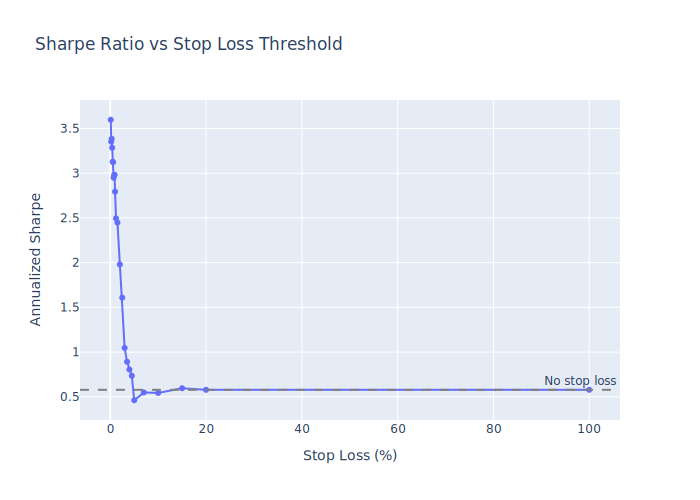

In [25]:
# Sharpe ratio sensitivity to stop loss threshold
import plotly.express as px

stop_loss_values = [-0.001, -0.002, -0.003, -0.004, -0.005, -0.006, -0.007, -0.008, 
                    -0.009, -0.01, -0.012, -0.015, -0.02, -0.025, -0.03, -0.035,
                    -0.04, -0.045, -0.05, -0.07, -0.10, -0.15, -0.20, -1.0]
results = []

for sl in stop_loss_values:
    pnl_temp = pd.DataFrame(index=rets.index)
    
    # Momentum strategies
    for n in lookback_days:
        signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
        signal = pd.Series(signal.values, index=rets.index)
        signal = apply_min_hold(signal, min_hold)
        signal = apply_stop_loss(signal, rets, sl)
        scaled = signal * vol_scalar
        pnl_temp[f'{n}D_momentum'] = scaled * rets - tcost * scaled.diff().abs()

    # Mean reversion (no stop loss applied here, same as main code)
    for n in lookback_days:
        signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
        signal = -signal
        pnl_temp[f'{n}D_meanrev'] = signal * rets - tcost * signal.diff().abs()

    # MA crossover strategies
    for fast, slow in ma_pairs:
        fast_ma = price.rolling(fast).mean()
        slow_ma = price.rolling(slow).mean()
        signal = (fast_ma.shift(1) > slow_ma.shift(1)) * 2 - 1
        signal = pd.Series(signal.values, index=rets.index)
        signal = apply_min_hold(signal, min_hold)
        signal = apply_stop_loss(signal, rets, sl)
        scaled = signal * vol_scalar
        pnl_temp[f'{fast}_{slow}_ma_cross'] = scaled * rets - tcost * scaled.diff().abs()

    # Run backtest for this stop loss value
    bt_temp = WalkforwardBacktester(
        pnl_df=pnl_temp.dropna(),
        lookback_period='24M',
        rebalance_freq='3M'
    )
    port = bt_temp.run_backtest()
    
    # Compute the Sharpe ratio
    sharpe = port.mean() / port.std() * np.sqrt(252)
    in_market = (port != 0).mean()
    
    results.append({
        'stop_loss': abs(sl) * 100,    # show as positive percentage
        'sharpe': sharpe,
        'in_market': in_market
    })
    print(f"Stop loss: {sl:>7.2%} | Sharpe: {sharpe:.2f} | In market: {in_market:.1%}")

res_df = pd.DataFrame(results)

# Plot the results
fig = px.line(res_df, x='stop_loss', y='sharpe', markers=True,
              title='Sharpe Ratio vs Stop Loss Threshold',
              labels={'stop_loss': 'Stop Loss (%)', 'sharpe': 'Annualized Sharpe'})
fig.add_hline(y=res_df[res_df['stop_loss'] == 100]['sharpe'].values[0], 
              line_dash='dash', line_color='gray',
              annotation_text='No stop loss')
fig.show()


---
## 8. Experimental / Disabled Analysis

The cell below has **commented-out code** for comparing rolling Sharpe ratios of momentum vs. mean reversion strategies. We disabled this because mean reversion signals just didn't produce any meaningful alpha for crude oil at these lookback periods.

In [26]:
# Rolling Sharpe of momentum vs mean reversion (disabled, see Section 8 notes)
# mom_rets = pnl_strategies['20D_momentum']
# mr_rets  = pnl_strategies['20D_meanrev']

# rolling_mom = mom_rets.rolling(126).mean() / mom_rets.rolling(126).std() * (252**0.5)
# rolling_mr  = mr_rets.rolling(126).mean() / mr_rets.rolling(126).std() * (252**0.5)

# pd.DataFrame({'Momentum': rolling_mom, 'MeanRev': rolling_mr}).plot(
#     title='Rolling 6M Sharpe: Momentum vs Mean Reversion')


---
## 9. Fundamental Data: EIA Crude Oil Inventories

The EIA (U.S. Energy Information Administration) publishes weekly crude oil inventory data. When inventories **draw down** (declining stocks), that's typically bullish for prices. When they **build up** (rising stocks), that's bearish.

Let's see if there's actually a tradeable signal hiding in the inventory numbers.

### 9.1 Load & Align Inventory Data

### 9.2 Inventory Change vs Oil Returns

Does the direction of the weekly inventory change predict same-week or next-week oil returns? We check correlations and visualize the relationship.

In [27]:
# Load EIA Crude Oil Inventory Data
# Try downloading the latest from EIA, fall back to local file if that fails
try:
    inv_raw = pd.read_excel(
        "https://ir.eia.gov/wpsr/psw01.xls",
        sheet_name="Data 1",
        header=2,
        index_col=0,
        parse_dates=True
    )
    print("Loaded inventory data from EIA website")
except Exception as e:
    print(f"Online download failed ({e}), using local file instead")
    inv_raw = pd.read_excel(
        "psw01.xls",
        sheet_name="Data 1",
        header=2,
        index_col=0,
        parse_dates=True
    )

# Print all available columns
for i, col in enumerate(inv_raw.columns):
    print(f"[{i}] {col}")


Online download failed (<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>), using local file instead
[0] Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
[1] Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)
[2] Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)
[3] Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)
[4] Weekly U.S. Ending Stocks of Reformulated Motor Gasoline  (Thousand Barrels)
[5] Weekly U.S. Ending Stocks of Conventional Motor Gasoline  (Thousand Barrels)
[6] Weekly U.S. Ending Stocks of Gasoline Blending Components  (Thousand Barrels)
[7] Weekly U.S. Ending Stocks of Fuel Ethanol  (Thousand Barrels)
[8] Weekly U.S. Ending Stocks of Kerosene-Type Jet Fuel  (Thousand Barrels)
[9] Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)
[10] Weekly U.S. Ending Stocks of Distillate Fuel Oil, 0 to 15 ppm Sulfur  (Thousan

In [28]:
# ── Select key inventory columns ───────────────────
inventory = inv_raw[[
    col for col in inv_raw.columns 
    if 'Crude Oil' in col and ('Ending Stocks' in col or 'Stock Change' in col)
]].copy()
# Shorten column names for readability
inventory.columns = [c.replace('Weekly ', '').replace('U.S. ', '').strip() 
                      for c in inventory.columns]
# ── Align with the daily price dataset ─────────────
# EIA inventory is reported weekly (Fridays). Forward-fill to daily frequency
# so each trading day uses the most recent available inventory reading.
# This avoids look-ahead bias — only past data is used.
inventory = inventory.reindex(rets.index).ffill()
# ── Verify date alignment ─────────────────────────
print(f"Price data range:     {rets.index[0].date()} → {rets.index[-1].date()}")
print(f"Inventory data range: {inventory.dropna().index[0].date()} → {inventory.dropna().index[-1].date()}")
print(f"Overlapping days:     {inventory.dropna().shape[0]}")
inventory.tail()

Price data range:     2016-01-04 → 2024-05-31
Inventory data range: 2016-01-08 → 2024-05-31
Overlapping days:     2170


,Ending Stocks of Crude Oil (Thousand Barrels),Ending Stocks excluding SPR of Crude Oil (Thousand Barrels),Ending Stocks of Crude Oil in SPR (Thousand Barrels),Ending Stocks of Crude Oil and Petroleum Products (Thousand Barrels),Ending Stocks excluding SPR of Crude Oil and Petroleum Products (Thousand Barrels)
date,,,,,
2024-05-27,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-28,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-29,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-30,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-31,826109.0,455922.0,370187.0,1646827.0,1276640.0


=== Correlation: Inventory Change vs Oil Returns ===
                      stock_change  oil_return_same_week  oil_return_next_week
stock_change                 1.000                -0.052                -0.134
oil_return_same_week        -0.052                 1.000                 0.058
oil_return_next_week        -0.134                 0.058                 1.000



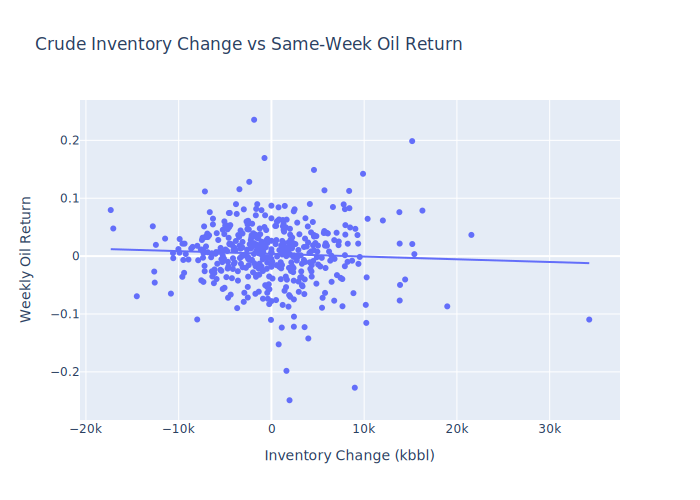

=== Average Weekly Return ===
When inventory BUILDS (bearish): -0.0005  (n=204)
When inventory DRAWS  (bullish): +0.0077  (n=222)
Difference:                      +0.0082


In [29]:
# Compute weekly stock change from ending stocks (excluding SPR = commercial only)
ending_stocks = inventory['Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)']
stock_change = ending_stocks.diff()

# Resample to weekly for analysis
weekly_rets = rets.resample('W-FRI').sum()
stock_change_weekly = stock_change.resample('W-FRI').last()

combined = pd.DataFrame({
    'stock_change': stock_change_weekly,
    'oil_return_same_week': weekly_rets,
    'oil_return_next_week': weekly_rets.shift(-1)
}).dropna()

print("=== Correlation: Inventory Change vs Oil Returns ===")
print(combined.corr().round(3))
print()

fig = px.scatter(combined, x='stock_change', y='oil_return_same_week',
                 trendline='ols',
                 title='Crude Inventory Change vs Same-Week Oil Return',
                 labels={'stock_change': 'Inventory Change (kbbl)', 
                         'oil_return_same_week': 'Weekly Oil Return'})
fig.show()

builds = combined[combined['stock_change'] > 0]['oil_return_same_week']
draws  = combined[combined['stock_change'] < 0]['oil_return_same_week']

print(f"=== Average Weekly Return ===")
print(f"When inventory BUILDS (bearish): {builds.mean():>+.4f}  (n={len(builds)})")
print(f"When inventory DRAWS  (bullish): {draws.mean():>+.4f}  (n={len(draws)})")
print(f"Difference:                      {draws.mean() - builds.mean():>+.4f}")